In [112]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np
import mshr

In [113]:
# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

volume =  4.0


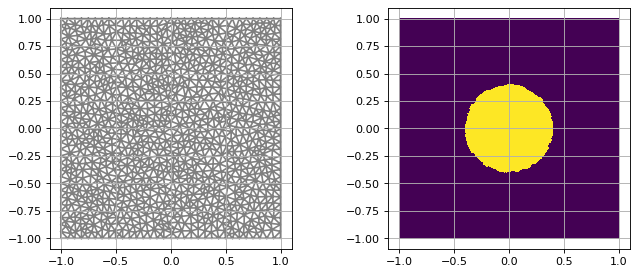

In [114]:
# Create the mesh for circular inclusion
vertices = np.array([[-1.0, -1.0], 
                    [1.0, -1.0], 
                    [1.0,  1.0],
                    [-1.0, 1.0]])
domain = mshr.Polygon([Point(vertices[0,:]), Point(vertices[1,:]), 
                       Point(vertices[2,:]), Point(vertices[3,:])])
inclusion = mshr.Circle(Point(0, 0), 0.4)
domain.set_subdomain(1, inclusion)

mesh = mshr.generate_mesh(domain, 24)
subdomain_marker = MeshFunction('size_t', mesh, mesh.topology().dim(),
                               mesh.domains())

# Compute volume of RVE
a = np.zeros((2, 2))      # direction vectors that define RVE.
a[0,:] = vertices[1,:] - vertices[0,:]
a[1,:] = vertices[3,:] - vertices[0,:]
vol = np.linalg.det(a); print("volume = ", vol)

# Vectors normal to direction vectors a.
n = np.zeros((2, 2))
n[0,:] = [a[0, 1], -a[0, 0]]
n[1,:] = [a[1, 1], -a[1, 0]]

assert np.dot(a[0,:], n[0,:]) < 1E-15
assert np.dot(a[1,:], n[1,:]) < 1E-15

# Plot the mesh and subdomains
plt.figure(figsize=(10, 4), dpi = 80)
plt.subplot(1,2,1)
plot(mesh); plt.grid()
plt.subplot(1,2,2)
plot(subdomain_marker); plt.grid()

In [115]:
# class used to define the periodic boundary map
class PeriodicBoundary(SubDomain):
    # Constructor
    def __init__(self, vertices, TOL=DOLFIN_EPS_LARGE):
        super().__init__()
        self.TOL = TOL
        self.vertices = vertices
        # vectors generating periodicity
        self.a = np.zeros((2, 2))
        self.a[0,:] = vertices[1,:] - vertices[0,:]
        self.a[1,:] = vertices[3,:] - vertices[0,:]
        
        # vectors normal to vectors a[0,:] and a[1,:]
        self.n = np.zeros((2,2))
        self.n[0,:] = [ -self.a[0,1], self.a[0,0] ]
        self.n[1,:] = [ -self.a[1,1], self.a[1,0] ]
        
        assert np.dot(self.n[0,:], self.a[0,:]) < self.TOL
        assert np.dot(self.n[1,:], self.a[1,:]) < self.TOL
    
    def inside(self, x, on_boundary):
        # return True if x is on the left or bottom boundaries
        # AND NOT on one of the bottom-right or top-left vertices
        top_left = np.allclose(x, self.vertices[3,:], self.TOL)
        bottom_right = np.allclose(x, self.vertices[1,:], self.TOL)
        x_vector = x - self.vertices[0,:]
        bottom = (np.abs(np.dot(self.n[0,:], x_vector)) < self.TOL)
        left = (np.abs(np.dot(self.n[1,:], x_vector)) < self.TOL)
            
        return (left or bottom) and \
            (not (top_left or bottom_right)) and on_boundary
    # Map right boundary (R) to the left boundary (L)
    def map(self, x, y):
        # top right node
        if np.allclose(x, self.vertices[2,:]):
            y[0] = x[0] - (self.a[0, 0] + self.a[1,0])
            y[1] = x[1] - (self.a[0, 1] + self.a[1,1])
        # right boundary
        elif np.abs(np.dot(self.n[1,:], x - self.vertices[1,:])) < self.TOL:
            y[0] = x[0] - self.a[0,0]
            y[1] = x[1] - self.a[0,1]
        # top boundary
        else:  
            y[0] = x[0] - self.a[1,0]
            y[1] = x[1] - self.a[1,1]

# Create an instance of periodic boundary condition
pbc = PeriodicBoundary(vertices)

In [116]:
# Create mesh and define function space
ElemU = VectorElement("CG", mesh.ufl_cell(), 2)
ElemL = VectorElement("R", mesh.ufl_cell(), 0)
W = VectorFunctionSpace(mesh, "Lagrange", 1, constrained_domain=pbc)


# Define functions
du = TrialFunction(W)
v = TestFunction(W)
u = Function(W)

# Macroscopic deformation gradient
F_Macro = Constant(np.array([[1.1, 0.0], [0.1, 1.05]]))

# The kinematic quantities involved in the model are defined using UFL syntax:
# Kinematics
d = len(u)                   # spatial dimension
F = F_Macro + Identity(d) + grad(u)    # deformation gradient
C = F.T * F                  # right cauchy-green tensor

# Invariants of deformation tensors
Ic = tr(C)
J = det(F)

In [117]:
# Mark boundary subdomains
def boundary(x, on_boundary):
    return (near(x[0], -1.0, 1E-10) and near(x[1], -1.0, 1E-10)) and on_boundary

bc = DirichletBC(W, Constant((0, 0)), boundary)

In [133]:
# Elastic parameters for two different phases
E = np.array([1.0, 5.0])
nu = np.array([0.33, 0.4])
mu_ = E/(2*1+nu)
lambda_ = E * nu /((1+nu) * (1-2*nu))

# Stored strain energy densities for two different materials.
psi_0 = 0.5 * mu_[0] * (Ic - 2) - mu_[0] * ln(J) + 0.5*lambda_[0] * ln(J)**2
psi_1 = 0.5 * mu_[1] * (Ic - 2) - mu_[1] * ln(J) + 0.5*lambda_[1] * ln(J)**2

In [134]:
# define the volume integral element
dx = Measure('dx', subdomain_data=subdomain_marker)

In [135]:
# Total potential energy
Pi = psi_0 * dx(0) + psi_1 * dx(1)

In [136]:
# Compute first variation of Pi
# namely, directional derive about u in the direction of v
F = derivative(Pi, u, v)
# Compute Jacobian of F
Jac_of_F = derivative(F, u, du)

In [137]:
A, b = assemble_system(Jac_of_F, F)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [139]:
# Solve variational problem
solve(F == 0, u, bc, J=Jac_of_F)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  74d7efe1e84d65e9433fd96c50f1d278fa3e3f3f
*** -------------------------------------------------------------------------
